# How to use RCall.jl and ggplot2 in Julia

Gen Kuroki

2020-08-23, 2021-06-09

References

* https://gist.github.com/genkuroki/04c9af425ce92073c0236fa7ea835c4d
* https://gist.github.com/genkuroki/e1def6d087fea3753b8dcd2cc2896d44
* http://juliainterop.github.io/RCall.jl/dev/internal/#RCall.ijulia_setdevice-Tuple{MIME}
* https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Rcall.jl" data-toc-modified-id="Load-Rcall.jl-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Rcall.jl</a></span><ul class="toc-item"><li><span><a href="#Impotant-to-do-Sys.setenv(LANG-=-&quot;en&quot;)" data-toc-modified-id="Impotant-to-do-Sys.setenv(LANG-=-&quot;en&quot;)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Impotant to do Sys.setenv(LANG = "en")</a></span></li><li><span><a href="#Utility-functions" data-toc-modified-id="Utility-functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Utility functions</a></span></li><li><span><a href="#Avoid-svg-display-bug" data-toc-modified-id="Avoid-svg-display-bug-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Avoid svg display bug</a></span></li></ul></li><li><span><a href="#Simple-ggplot2-example" data-toc-modified-id="Simple-ggplot2-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple ggplot2 example</a></span></li><li><span><a href="#How-to-use-R's-fisher.test-and-exact2x2::fisher.exact" data-toc-modified-id="How-to-use-R's-fisher.test-and-exact2x2::fisher.exact-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>How to use R's fisher.test and exact2x2::fisher.exact</a></span><ul class="toc-item"><li><span><a href="#fisher.test" data-toc-modified-id="fisher.test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>fisher.test</a></span></li><li><span><a href="#exact2x2::fisher.exact" data-toc-modified-id="exact2x2::fisher.exact-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>exact2x2::fisher.exact</a></span></li></ul></li><li><span><a href="#Simple-ggplot2-examples" data-toc-modified-id="Simple-ggplot2-examples-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simple ggplot2 examples</a></span></li></ul></div>

## Load Rcall.jl

### Impotant to do Sys.setenv(LANG = "en")

In [1]:
using DataFrames

using RCall
@rimport base as R
#R.Sys_setenv(LANG = "en") # 2020-08-23 これを実行しておかないとハングすることがある.

macro sym_str(x) :(Symbol($(esc(x)))) end
@show sym"conf.int";

sym"conf.int" = Symbol("conf.int")


### Utility functions

In [2]:
rcalljl_options(; kwargs...) = rcopy(RCall.rcall_p(:options, rcalljl_options=Dict(kwargs)))

function rplotsize(w, h)
    if RCall.ijulia_mime == MIME("image/svg+xml")
        rcalljl_options(; width=w/100, height=h/100)
    else
        rcalljl_options(; width=w, height=h)
    end
end

function rplotpng(; kwargs...)
    RCall.ijulia_setdevice(MIME("image/png"); kwargs...)
    RCall.ijulia_mime, rcalljl_options()
end

function rplotsvg(; kwargs...)
    RCall.ijulia_setdevice(MIME("image/svg+xml"); kwargs...)
    RCall.ijulia_mime, rcalljl_options()
end

rplotsvg (generic function with 1 method)

### Avoid svg display bug

https://github.com/JuliaInterop/RCall.jl/blob/master/src/ijulia.jl#L37-L48

In [3]:
# original

# function RCall.ijulia_displayfile(m::MIME"image/svg+xml", f)
#     # R svg images use named defs, which cause problem when used inline, see
#     # https://github.com/jupyter/notebook/issues/333
#     # we get around this by renaming the elements.
#     open(f) do f
#         r = RCall.randstring()
#         d = read(f, String)
#         d = replace(d, "id=\"glyph" => "id=\"glyph"*r)
#         d = replace(d, "href=\"#glyph" => "href=\"#glyph"*r)
#         display(m,d)
#     end
# end

In [4]:
# using Base64

# function RCall.ijulia_displayfile(m::MIME"image/svg+xml", f)
#     open(f) do io
#         svg = read(io, String)
#         base64 = base64encode(svg)
#         html = """<img src="data:$m;base64,$base64" />"""
#         display(MIME("text/html"), html)
#     end
# end

## Simple ggplot2 example

In [5]:
@rlibrary ggplot2
rplotsvg()

(MIME type image/svg+xml, OrderedCollections.OrderedDict{Symbol, Any}(:rcalljl_options => OrderedCollections.OrderedDict{Symbol, Any}(:height => 5, :width => 6)))

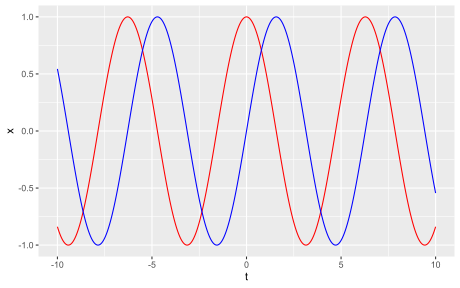

RObject{VecSxp}


┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = iterate(x::Base.Pairs{Int64, ListSxp, Base.OneTo{Int64}, Ptr{ListSxp}}) at methods.jl:232
└ @ RCall D:\.julia\packages\RCall\3mHXJ\src\methods.jl:232


In [6]:
rplotsize(640, 400)
t = range(-10, 10, length=1000)
data = DataFrame(t = t, x = cos.(t), y = sin.(t))
ggplot(data=data, aes(x=:t, y=:x)) + 
geom_line(color="red") +
geom_line(aes(y=:y), color="blue")

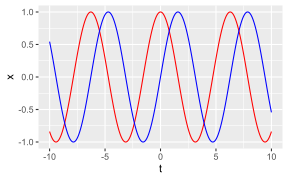

RObject{VecSxp}


rplotsize(400, 250) = OrderedCollections.OrderedDict{Symbol, Any}(:rcalljl_options => OrderedCollections.OrderedDict{Symbol, Any}(:height => 4.0, :width => 6.4))


In [7]:
# プロットの表示サイズの変更のテスト

@show rplotsize(400, 250)
sleep(0.1)

P = ggplot(data=data, aes(x=:t, y=:x)) + 
geom_line(color="red") +
geom_line(aes(y=:y), color="blue")
display(P)

## How to use R's fisher.test and exact2x2::fisher.exact

### fisher.test

In [8]:
@rlibrary stats # R の fisher.test などが fisher_test という名前で使えるようになる

In [9]:
A = [
    10 10
     7 27
]

f = fisher_test(A) # P値が5%未満なのに, 95%信頼区間が1を含む

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  structure(c(10L, 7L, 10L, 27L), .Dim = c(2L, 2L))
p-value = 0.03516
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.9836015 15.3827687
sample estimates:
odds ratio 
  3.751532 



In [10]:
f = rcopy(f) # RObject の h を Julia の object に変換

OrderedCollections.OrderedDict{Symbol, Any} with 7 entries:
  :p_value     => 0.0351564
  :conf_int    => [0.983602, 15.3828]
  :estimate    => 3.75153
  :null_value  => 1.0
  :alternative => "two.sided"
  :method      => "Fisher's Exact Test for Count Data"
  :data_name   => "structure(c(10L, 7L, 10L, 27L), .Dim = c(2L, 2L))"

In [11]:
@show f[:p_value]
@show f[:conf_int];

f[:p_value] = 0.03515636840648692
f[:conf_int] = [0.9836015045314647, 15.382768670334402]


### exact2x2::fisher.exact

In [12]:
@rlibrary exact2x2
rcall(:library, :exact2x2) # これがないと fisher_exact の利用で exact2x2 が見付からないと怒られる

┌ Warning: RCall.jl: Loading required package: exactci
│ Loading required package: ssanv
└ @ RCall D:\.julia\packages\RCall\3mHXJ\src\io.jl:160


RObject{StrSxp}
 [1] "exact2x2"  "exactci"   "ssanv"     "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     


In [13]:
g = fisher_exact(A) # P値が5%未満なので, 95%信頼区間が1を含まない(正常な結果)

RObject{VecSxp}

	Two-sided Fisher's Exact Test (usual method using minimum likelihood)

data:  structure(c(10L, 7L, 10L, 27L), .Dim = c(2L, 2L))
p-value = 0.03516
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  1.0691 13.4926
sample estimates:
odds ratio 
  3.751532 



In [14]:
g = rcopy(g)　# RObject の g を Julia の object に変換

OrderedCollections.OrderedDict{Symbol, Any} with 7 entries:
  :p_value     => 0.0351564
  :conf_int    => [1.0691, 13.4926]
  :estimate    => 3.75153
  :null_value  => 1.0
  :alternative => "two.sided"
  :method      => "Two-sided Fisher's Exact Test (usual method using minimum li…
  :data_name   => "structure(c(10L, 7L, 10L, 27L), .Dim = c(2L, 2L))"

In [15]:
@show g[:p_value]
@show g[:conf_int];

g[:p_value] = 0.03515636840648692
g[:conf_int] = [1.0691, 13.4926]


In [16]:
# 上と同様のことを別の方法で実現

rcall(:library, :exact2x2)
@rput A
R"""h = fisher.exact(A)"""
@rget h

OrderedCollections.OrderedDict{Symbol, Any} with 7 entries:
  :p_value     => 0.0351564
  :conf_int    => [1.0691, 13.4926]
  :estimate    => 3.75153
  :null_value  => 1.0
  :alternative => "two.sided"
  :method      => "Two-sided Fisher's Exact Test (usual method using minimum li…
  :data_name   => "A"

In [17]:
@show h[:p_value]
@show h[:conf_int];

h[:p_value] = 0.03515636840648692
h[:conf_int] = [1.0691, 13.4926]


## Simple ggplot2 examples

* https://rstudio-pubs-static.s3.amazonaws.com/12581_042080eb6d9a498da1f7dc99238e2efc.html

In [18]:
R"mtcars <- mtcars"
@rget mtcars
first(mtcars, 5)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,21.0,6.0,160.0,110.0,3.9,2.62,16.46,0.0,1.0
2,21.0,6.0,160.0,110.0,3.9,2.875,17.02,0.0,1.0
3,22.8,4.0,108.0,93.0,3.85,2.32,18.61,1.0,1.0
4,21.4,6.0,258.0,110.0,3.08,3.215,19.44,1.0,0.0
5,18.7,8.0,360.0,175.0,3.15,3.44,17.02,0.0,0.0


In [19]:
R"""
library(ggplot2)
library(ggplot2movies)
movies <- movies
# Select 1000 of the movies
movies <- movies[sample(nrow(movies), 1000), ]
"""
@rget movies
first(movies, 5)

,title,year,length,budget,rating,votes,r1,r2
,String,Int64,Int64,Int64?,Float64,Int64,Float64,Float64
1,"Nacht im Mai, Eine",1938,88,missing,6.6,7,0.0,0.0
2,Solomon Bernstein's Bathroom,2000,20,35000,6.4,9,14.5,14.5
3,"Parallelle lig, Det",1982,85,missing,5.9,28,4.5,0.0
4,Battle Circus,1953,90,missing,5.4,158,4.5,4.5
5,"Greener Hills, The",1939,11,missing,5.0,8,0.0,0.0


In [20]:
rplotsvg()

(MIME type image/svg+xml, OrderedCollections.OrderedDict{Symbol, Any}(:rcalljl_options => OrderedCollections.OrderedDict{Symbol, Any}(:height => 5, :width => 6)))

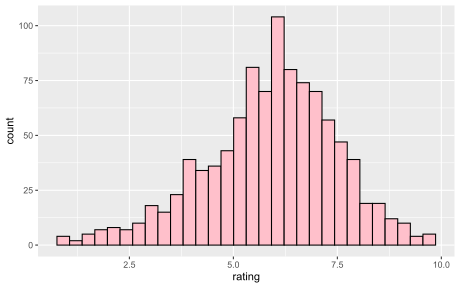

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall D:\.julia\packages\RCall\3mHXJ\src\io.jl:160


In [21]:
rplotsize(640, 400)
p = ggplot(data=movies, aes(x=:rating)) # raring -> :rating
p + geom_histogram(color="black", fill="pink")  # default bins

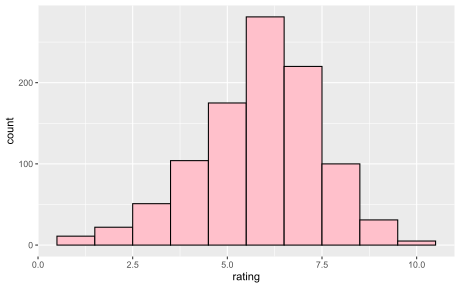

RObject{VecSxp}


In [22]:
p + geom_histogram(binwidth=1, color="black", fill="pink")  # big bins

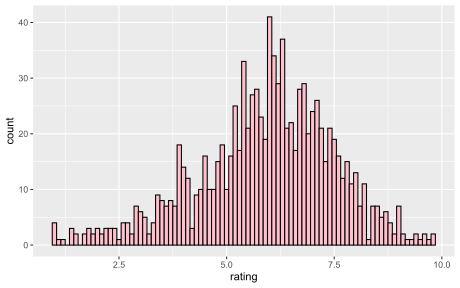

RObject{VecSxp}


In [23]:
p + geom_histogram(binwidth=0.1, color="black", fill="pink")  # small bins

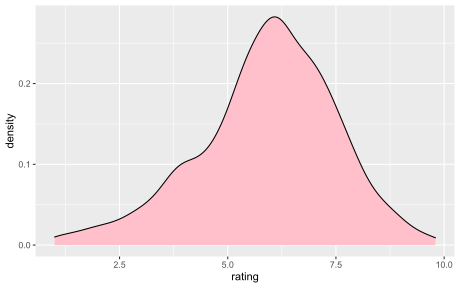

RObject{VecSxp}


In [24]:
p + geom_density(fill="pink")

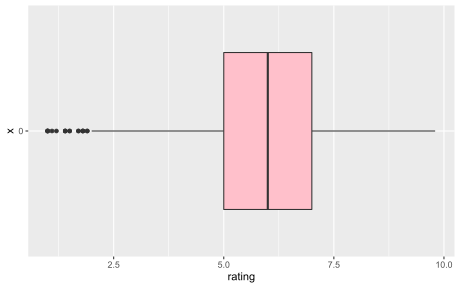

RObject{VecSxp}


In [25]:
# Boxplot
m = ggplot(data=movies, aes(y=:rating, x=R.factor(0))) # rating, factor -> :rating, R.factor
m + geom_boxplot(fill="pink") + coord_flip()

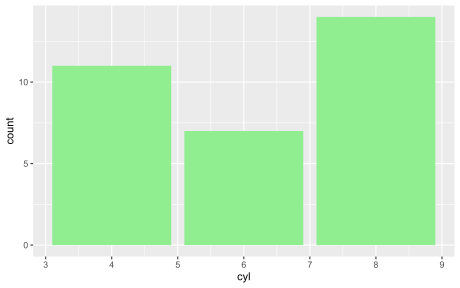

RObject{VecSxp}


In [26]:
c = ggplot(mtcars, R"aes(cyl)") # aes(cyl) -> R"aes(cyl)"
c + geom_bar(fill="lightgreen")

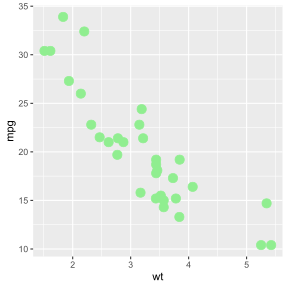

RObject{VecSxp}


In [27]:
rplotsize(400, 400)
p = ggplot(mtcars, R"aes(wt, mpg)")
p + geom_point(size=4, color="lightgreen")

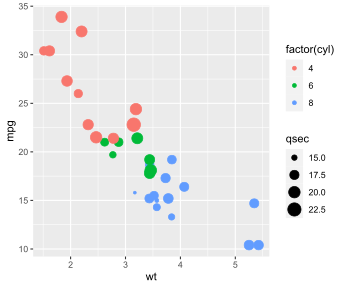

RObject{VecSxp}


In [28]:
rplotsize(480, 400)
p + geom_point(R"aes(colour=factor(cyl), size = qsec)")

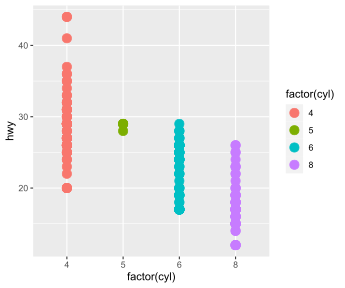

RObject{VecSxp}


In [29]:
rplotsize(480, 400)
p = ggplot(:mpg, R"aes(factor(cyl), hwy, colour=factor(cyl))")
p + geom_point(size=4)  # Overlaid dots

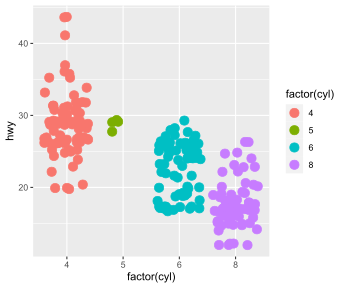

RObject{VecSxp}


In [30]:
p + geom_point(size=4, position="jitter")  # Jittered dots

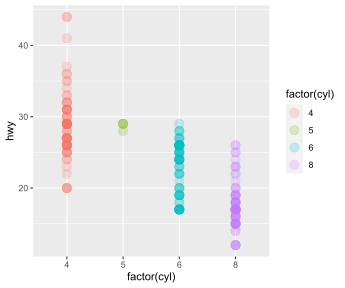

RObject{VecSxp}


In [31]:
p + geom_point(size=4, alpha=.2)  # Transparent dots

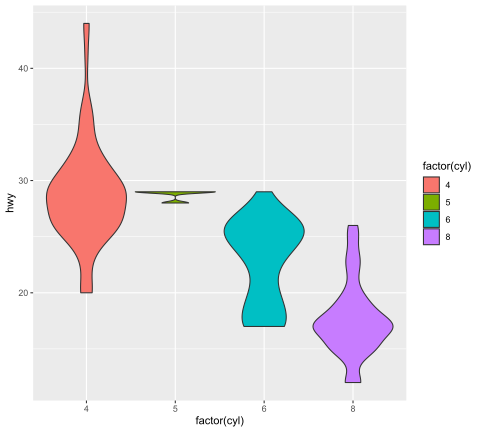

RObject{VecSxp}


In [32]:
rplotsize(670, 600)
p = ggplot(:mpg, R"aes(x=factor(cyl), y=hwy, fill=factor(cyl))")
p + geom_violin(scale = "width")

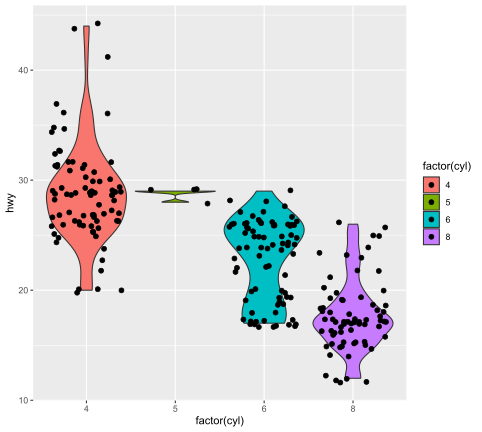

RObject{VecSxp}


In [33]:
p + geom_violin(scale = "width") + geom_point(size=2, position="jitter")

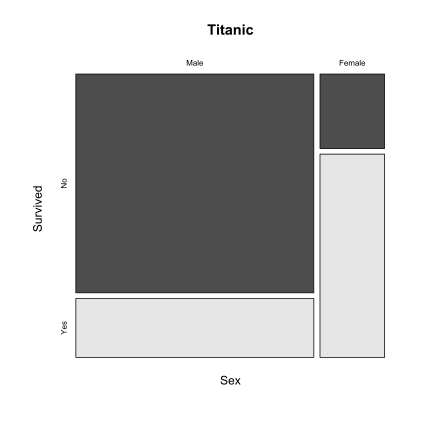

RObject{NilSxp}
NULL


In [34]:
rplotsize(600, 600)
R"""mosaicplot(~ Sex + Survived, data = Titanic, color = TRUE)"""

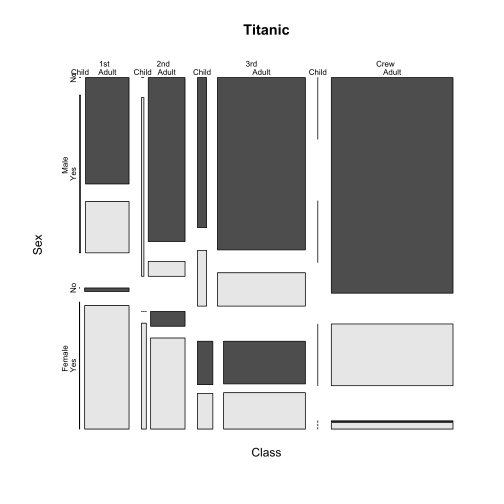

RObject{NilSxp}
NULL


In [35]:
rplotsize(700, 700)
R"""mosaicplot(Titanic, color = TRUE)"""

In [36]:
R"""
# Coefficient plots
library(coefplot)  # Install this package
model1 <- lm(mpg ~ wt + disp + hp + factor(cyl), data=mtcars)
summary(model1)
"""

RObject{VecSxp}

Call:
lm(formula = mpg ~ wt + disp + hp + factor(cyl), data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2740 -1.0349 -0.3831  0.9810  5.4192 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  36.002405   2.130726  16.897 1.54e-15 ***
wt           -3.428626   1.055455  -3.248  0.00319 ** 
disp          0.004199   0.012917   0.325  0.74774    
hp           -0.023517   0.012216  -1.925  0.06523 .  
factor(cyl)6 -3.466011   1.462979  -2.369  0.02554 *  
factor(cyl)8 -3.753227   2.813996  -1.334  0.19385    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.482 on 26 degrees of freedom
Multiple R-squared:  0.8578,	Adjusted R-squared:  0.8305 
F-statistic: 31.37 on 5 and 26 DF,  p-value: 3.18e-10



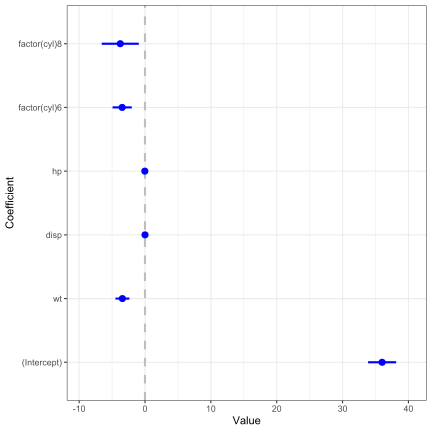

RObject{VecSxp}


In [37]:
rplotsize(600, 600)
R"""coefplot(model1) + labs(title=NULL) + theme_bw()"""

In [38]:
R"""
# Scatterplot matrix
library(car)
"""

┌ Warning: RCall.jl: Loading required package: carData
└ @ RCall D:\.julia\packages\RCall\3mHXJ\src\io.jl:160


RObject{StrSxp}
 [1] "car"           "carData"       "coefplot"      "ggplot2movies"
 [5] "ggplot2"       "exact2x2"      "exactci"       "ssanv"        
 [9] "stats"         "graphics"      "grDevices"     "utils"        
[13] "datasets"      "methods"       "base"         


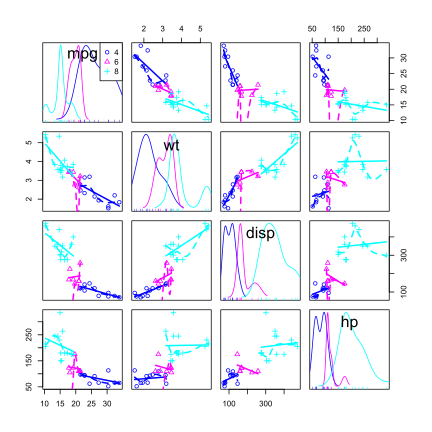

┌ Warning: RCall.jl: Warning in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE,  :
│   could not fit smooth
└ @ RCall D:\.julia\packages\RCall\3mHXJ\src\io.jl:160


RObject{NilSxp}
NULL


In [39]:
R"""scatterplotMatrix(~ mpg + wt + disp + hp | cyl, data=mtcars, main=NULL)"""